# Salary Prediction with Machine Learning

### Explanation

The main goal of this project is to build a machine learning model that accurately predicts the salaries of baseball players.

### About Dataset

A data frame with 322 observations of major league players on the following 20 variables:

* **AtBat**: Number of times at bat in 1986
 
* **Hits**: Number of hits in 1986
 
* **HmRun**: Number of home runs in 1986
 
* **Runs**: Number of runs in 1986
 
* **RBI**: Number of runs batted in in 1986
 
* **Walks**: Number of walks in 1986
 
* **Years**: Number of years in the major leagues
 
* **CAtBat**: Number of times at bat during his career
 
* **CHits**: Number of hits during his career
 
* **CHmRun**: Number of home runs during his career
 
* **CRuns**: Number of runs during his career
 
* **CRBI**: Number of runs batted in during his career
 
* **CWalks**: Number of walks during his career
 
* **League**: A factor with levels A and N indicating player's league at the end of 1986

* **Division**: A factor with levels E and W indicating player's division at the end of 1986
 
* **PutOuts**: Number of put outs in 1986
 
* **Assists**: Number of assists in 1986
 
* **Errors**: Number of errors in 1986
 
* **Salary**: 1987 annual salary on opening day in thousands of dollars
 
* **NewLeague**: A factor with levels A and N indicating player's league at the beginning of 1987

### Importing Dataset and Libraries

In [4]:
import numpy as np
import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, RobustScaler

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score, validation_curve

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 170)
pd.set_option('display.max_rows', 20)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

from sklearn.exceptions import ConvergenceWarning

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action="ignore", category=ConvergenceWarning)

In [5]:
hitters = pd.read_csv("C:/Users/bartu/PycharmProjects/pythonProject1/Hitters.csv")
df = hitters.copy()
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.000,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.000,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.000,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.500,N


### Exploratory Data Analysis

#### Basic Information

In [6]:
def check_df(dataframe):
    print("---------------Head---------------")
    print(dataframe.head())
    print("---------------Shape---------------")
    print(dataframe.shape)
    print("---------------Describe---------------")
    print(dataframe.describe().T)
    print("---------------Null Values---------------")
    print(dataframe.isnull().sum())
    print("---------------Tail---------------")
    print(dataframe.tail())
    print("---------------Types---------------")
    print(dataframe.dtypes)

check_df(df)

---------------Head---------------
   AtBat  Hits  HmRun  Runs  RBI  Walks  Years  CAtBat  CHits  CHmRun  CRuns  CRBI  CWalks League Division  PutOuts  Assists  Errors  Salary NewLeague
0    293    66      1    30   29     14      1     293     66       1     30    29      14      A        E      446       33      20     NaN         A
1    315    81      7    24   38     39     14    3449    835      69    321   414     375      N        W      632       43      10 475.000         N
2    479   130     18    66   72     76      3    1624    457      63    224   266     263      A        W      880       82      14 480.000         A
3    496   141     20    65   78     37     11    5628   1575     225    828   838     354      N        E      200       11       3 500.000         N
4    321    87     10    39   42     30      2     396    101      12     48    46      33      N        E      805       40       4  91.500         N
---------------Shape---------------
(322, 20)
-------------

In [7]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    It gives the names of categorical, numerical and categorical but cardinal variables in the data set.
     Note: Categorical variables with numerical appearance are also included in categorical variables.

    Parameters
    ------
        dataframe: dataframe
                The dataframe from which variable names are to be retrieved
        cat_th: int, optional
                Class threshold for numeric but categorical variables
        car_th: int, optinal
                Class threshold for categorical but cardinal variables

    Returns
    ------
        cat_cols: list
                Categorical Variables List
        num_cols: list
                Numeric Variables List
        cat_but_car: list
                Cardinal Variables List That Seems Categorical

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = Total Number of Variables
        cat_cols includes num_but_cat
        The sum of 3 lists with return is equal to the total number of variables: cat_cols + num_cols + cat_but_car = number of variables

    """


    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 322
Variables: 20
cat_cols: 3
num_cols: 17
cat_but_car: 0
num_but_cat: 0


#### Analysis of Numerical Variables 

In [8]:
def num_summary(dataframe, numerical_col, plot=False):

    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]

    print(dataframe[numerical_col].describe(quantiles).T)
    print(f"\n##### Plot #####\n")
    
    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()

count   322.000
mean    380.929
std     153.405
min      16.000
5%      161.000
10%     194.100
20%     221.800
30%     281.300
40%     321.800
50%     379.500
60%     430.200
70%     490.000
80%     535.600
90%     584.900
95%     609.900
99%     658.590
max     687.000
Name: AtBat, dtype: float64

##### Plot #####



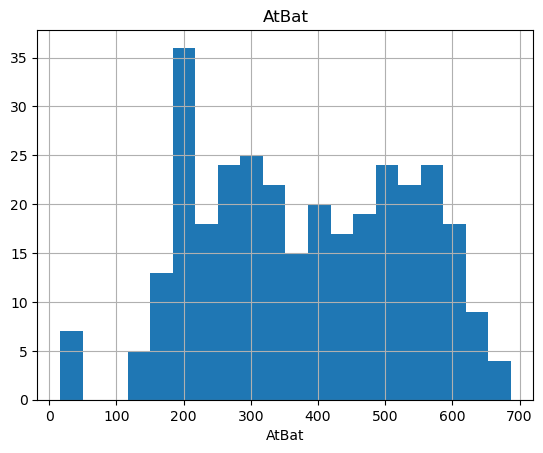

count   322.000
mean    101.025
std      46.455
min       1.000
5%       39.000
10%      45.100
20%      57.000
30%      70.000
40%      82.000
50%      96.000
60%     113.000
70%     128.700
80%     144.000
90%     163.000
95%     174.000
99%     210.790
max     238.000
Name: Hits, dtype: float64

##### Plot #####



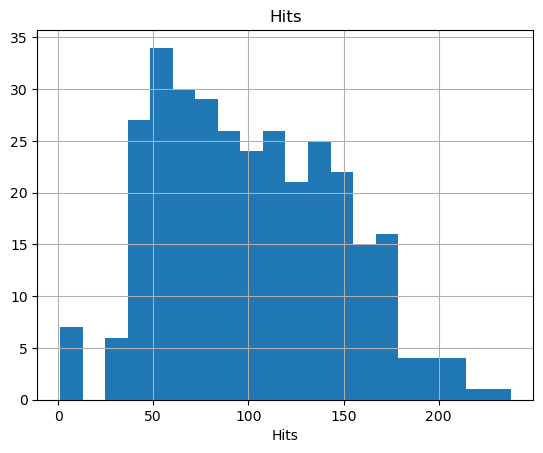

count   322.000
mean     10.770
std       8.709
min       0.000
5%        0.000
10%       1.000
20%       3.000
30%       5.000
40%       6.000
50%       8.000
60%      10.600
70%      14.000
80%      18.000
90%      24.000
95%      28.950
99%      33.000
max      40.000
Name: HmRun, dtype: float64

##### Plot #####



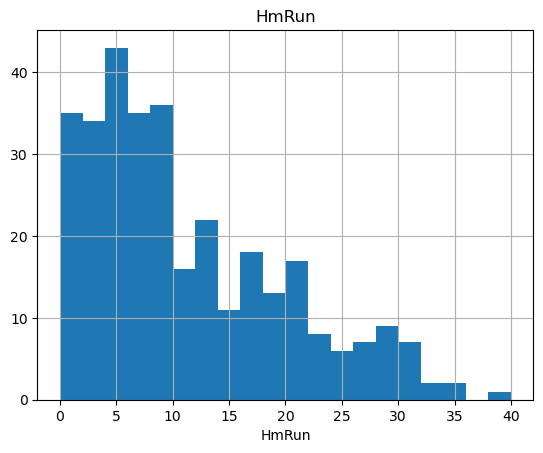

count   322.000
mean     50.910
std      26.024
min       0.000
5%       17.000
10%      20.100
20%      27.000
30%      33.000
40%      41.000
50%      48.000
60%      55.600
70%      66.000
80%      75.800
90%      89.000
95%      94.000
99%     107.790
max     130.000
Name: Runs, dtype: float64

##### Plot #####



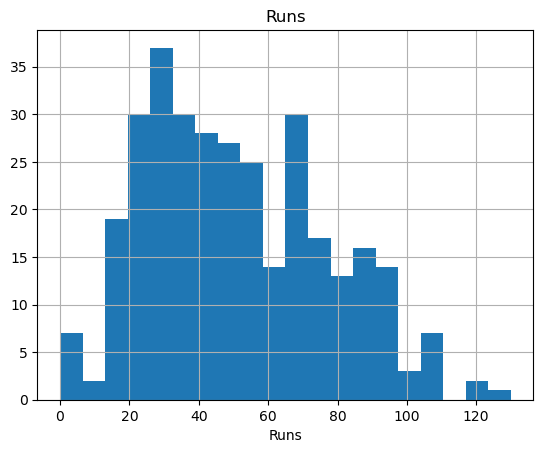

count   322.000
mean     48.028
std      26.167
min       0.000
5%       14.000
10%      19.000
20%      26.000
30%      30.000
40%      36.400
50%      44.000
60%      49.000
70%      58.000
80%      73.000
90%      86.000
95%      96.000
99%     112.370
max     121.000
Name: RBI, dtype: float64

##### Plot #####



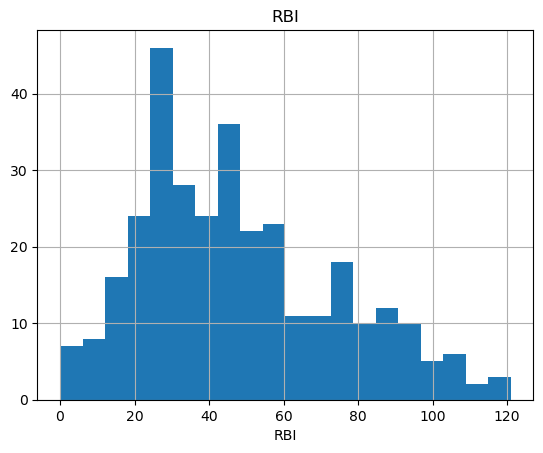

count   322.000
mean     38.742
std      21.639
min       0.000
5%       11.050
10%      15.000
20%      20.000
30%      24.000
40%      30.000
50%      35.000
60%      40.000
70%      48.700
80%      59.000
90%      69.900
95%      78.000
99%      93.580
max     105.000
Name: Walks, dtype: float64

##### Plot #####



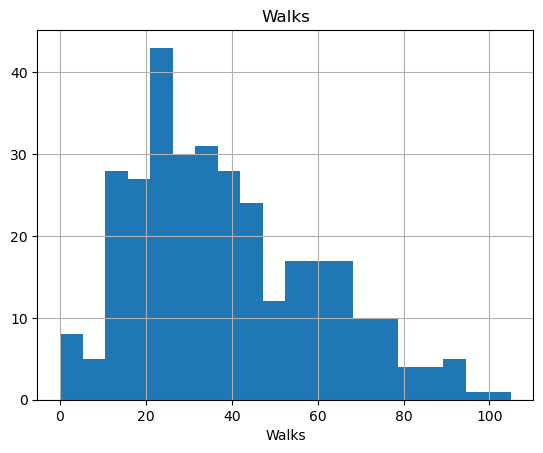

count   322.000
mean      7.444
std       4.926
min       1.000
5%        1.000
10%       2.000
20%       3.000
30%       4.000
40%       5.000
50%       6.000
60%       7.600
70%      10.000
80%      12.000
90%      15.000
95%      17.000
99%      19.790
max      24.000
Name: Years, dtype: float64

##### Plot #####



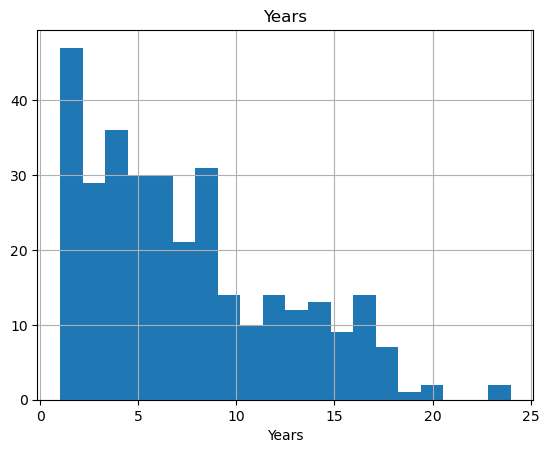

count     322.000
mean     2648.683
std      2324.206
min        19.000
5%        216.500
10%       342.200
20%       667.600
30%       963.400
40%      1402.200
50%      1928.000
60%      2654.000
70%      3365.000
80%      4483.000
90%      6123.400
95%      7125.600
99%      8749.970
max     14053.000
Name: CAtBat, dtype: float64

##### Plot #####



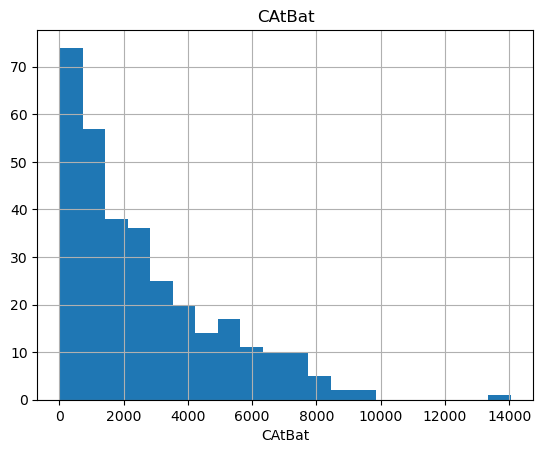

count    322.000
mean     717.571
std      654.473
min        4.000
5%        54.000
10%       86.000
20%      164.600
30%      238.000
40%      355.800
50%      508.000
60%      708.200
70%      911.100
80%     1229.200
90%     1659.600
95%     2017.150
99%     2500.340
max     4256.000
Name: CHits, dtype: float64

##### Plot #####



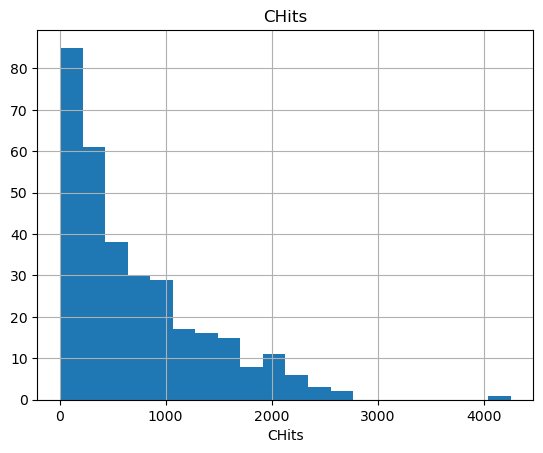

count   322.000
mean     69.491
std      86.266
min       0.000
5%        2.000
10%       4.000
20%      10.200
30%      16.300
40%      27.400
50%      37.500
60%      51.200
70%      72.400
80%     103.800
90%     194.900
95%     265.650
99%     373.120
max     548.000
Name: CHmRun, dtype: float64

##### Plot #####



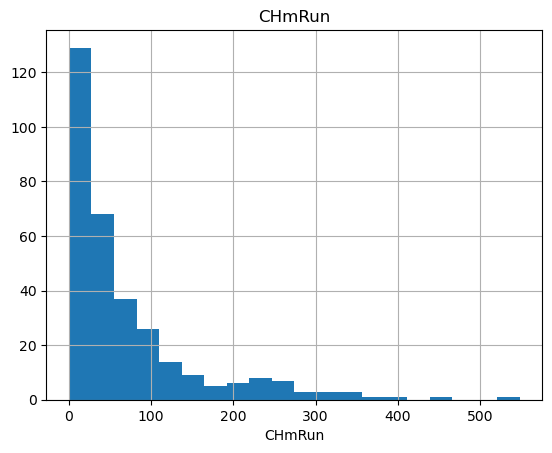

count    322.000
mean     358.795
std      334.106
min        1.000
5%        27.000
10%       38.100
20%       80.400
30%      117.300
40%      181.000
50%      247.000
60%      333.000
70%      443.400
80%      627.200
90%      895.700
95%     1032.300
99%     1174.370
max     2165.000
Name: CRuns, dtype: float64

##### Plot #####



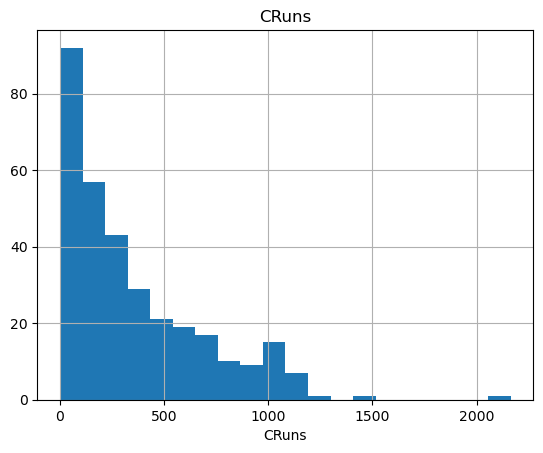

count    322.000
mean     330.118
std      333.220
min        0.000
5%        22.050
10%       34.100
20%       70.200
30%      106.300
40%      149.000
50%      220.500
60%      303.600
70%      379.100
80%      496.200
90%      861.600
95%     1071.750
99%     1310.850
max     1659.000
Name: CRBI, dtype: float64

##### Plot #####



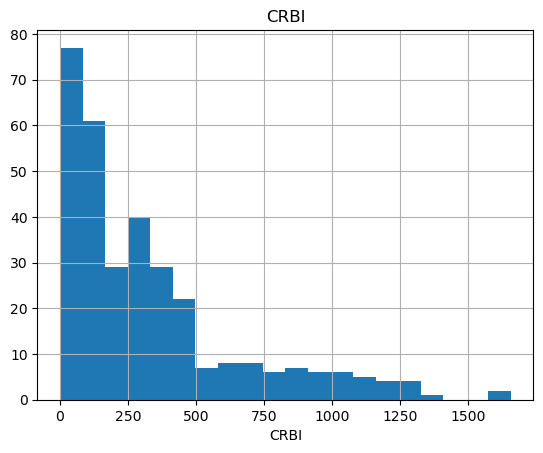

count    322.000
mean     260.239
std      267.058
min        0.000
5%        15.050
10%       30.100
20%       55.000
30%       82.000
40%      117.400
50%      170.500
60%      226.600
70%      300.700
80%      421.000
90%      643.900
95%      817.600
99%     1139.140
max     1566.000
Name: CWalks, dtype: float64

##### Plot #####



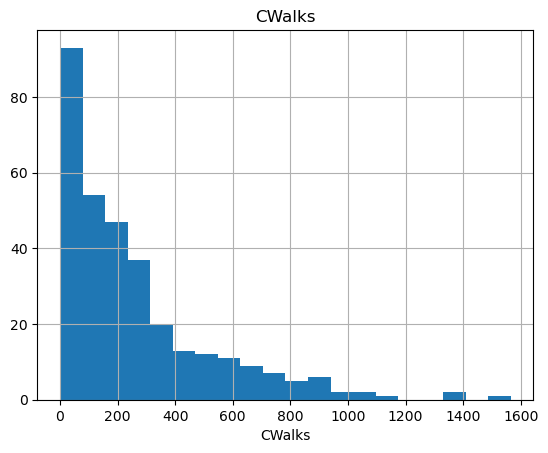

count    322.000
mean     288.938
std      280.705
min        0.000
5%        33.200
10%       62.200
20%       99.600
30%      132.000
40%      167.000
50%      212.000
60%      257.400
70%      303.000
80%      365.800
90%      685.600
95%      910.650
99%     1301.190
max     1378.000
Name: PutOuts, dtype: float64

##### Plot #####



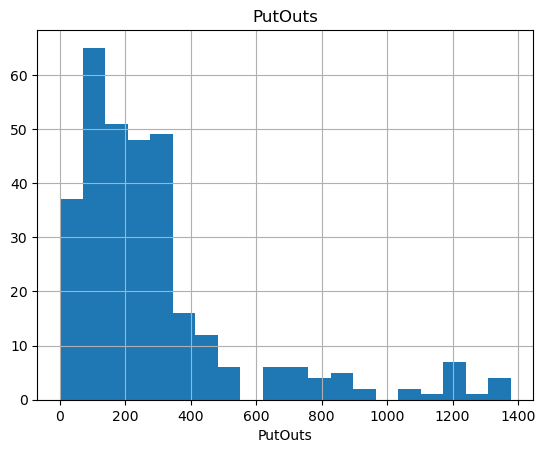

count   322.000
mean    106.913
std     136.855
min       0.000
5%        0.000
10%       2.000
20%       5.200
30%       9.000
40%      15.400
50%      39.500
60%      76.800
70%     134.800
80%     210.800
90%     353.300
95%     431.450
99%     478.160
max     492.000
Name: Assists, dtype: float64

##### Plot #####



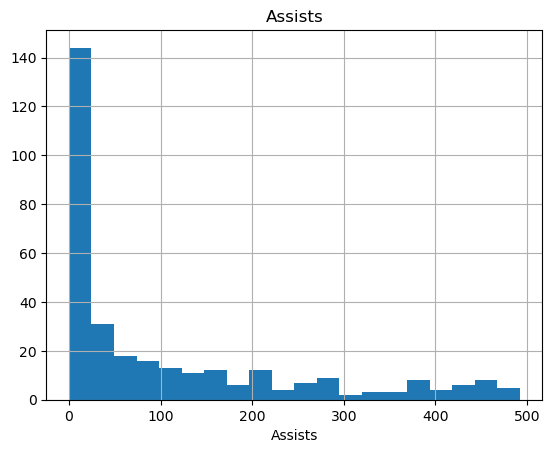

count   322.000
mean      8.040
std       6.368
min       0.000
5%        0.000
10%       1.000
20%       3.000
30%       4.000
40%       5.000
50%       6.000
60%       8.000
70%      10.000
80%      13.000
90%      17.000
95%      20.000
99%      25.790
max      32.000
Name: Errors, dtype: float64

##### Plot #####



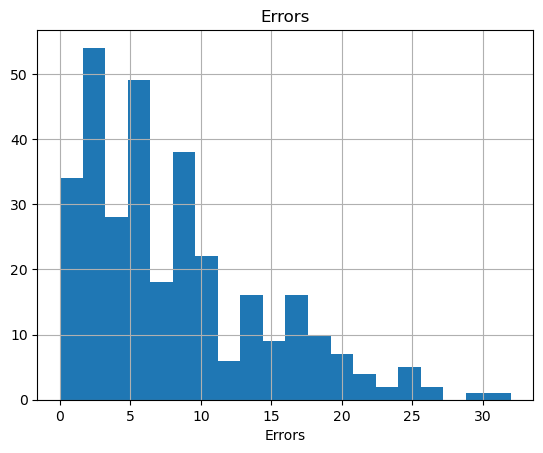

count    263.000
mean     535.926
std      451.119
min       67.500
5%        86.600
10%      100.000
20%      155.000
30%      221.000
40%      300.000
50%      425.000
60%      538.000
70%      700.000
80%      809.000
90%     1048.667
95%     1346.000
99%     2032.887
max     2460.000
Name: Salary, dtype: float64

##### Plot #####



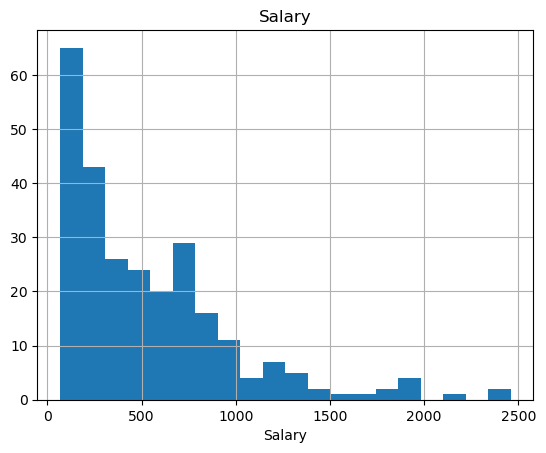

In [9]:
for col in num_cols:
    num_summary(df, col, plot=True)

#### Analysis of Categorical Variables

In [10]:
def cat_summary(dataframe, col_name, plot=False):

    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print(f"######################\n")

    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()

   League  Ratio
A     175 54.348
N     147 45.652
######################



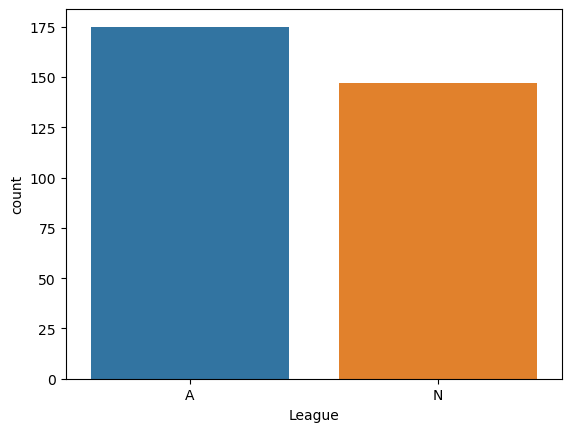

   Division  Ratio
W       165 51.242
E       157 48.758
######################



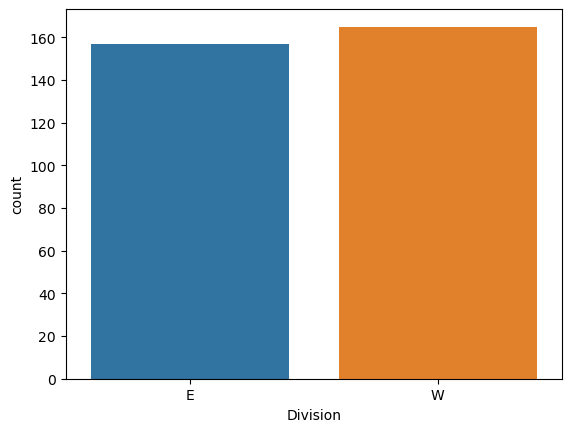

   NewLeague  Ratio
A        176 54.658
N        146 45.342
######################



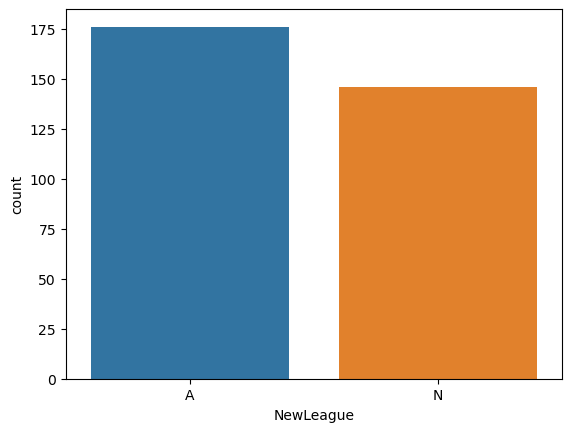

In [11]:
for col in cat_cols:
    cat_summary(df, col, plot=True)

#### Correlation

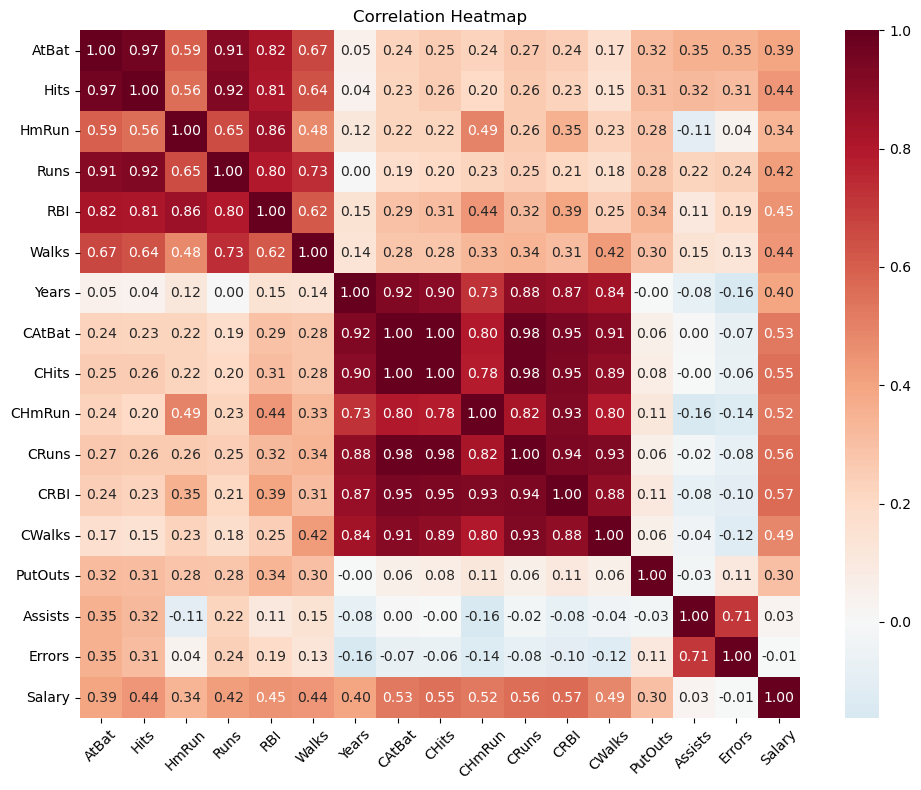

In [12]:
corr_matrix = df.corr()
# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Create a heatmap using Seaborn
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="RdBu_r", center=0)

# Customize the appearance
plt.title('Correlation Heatmap')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()

# Show the plot
plt.show()

### Data Preprocessing

#### Missing Values

<AxesSubplot:>

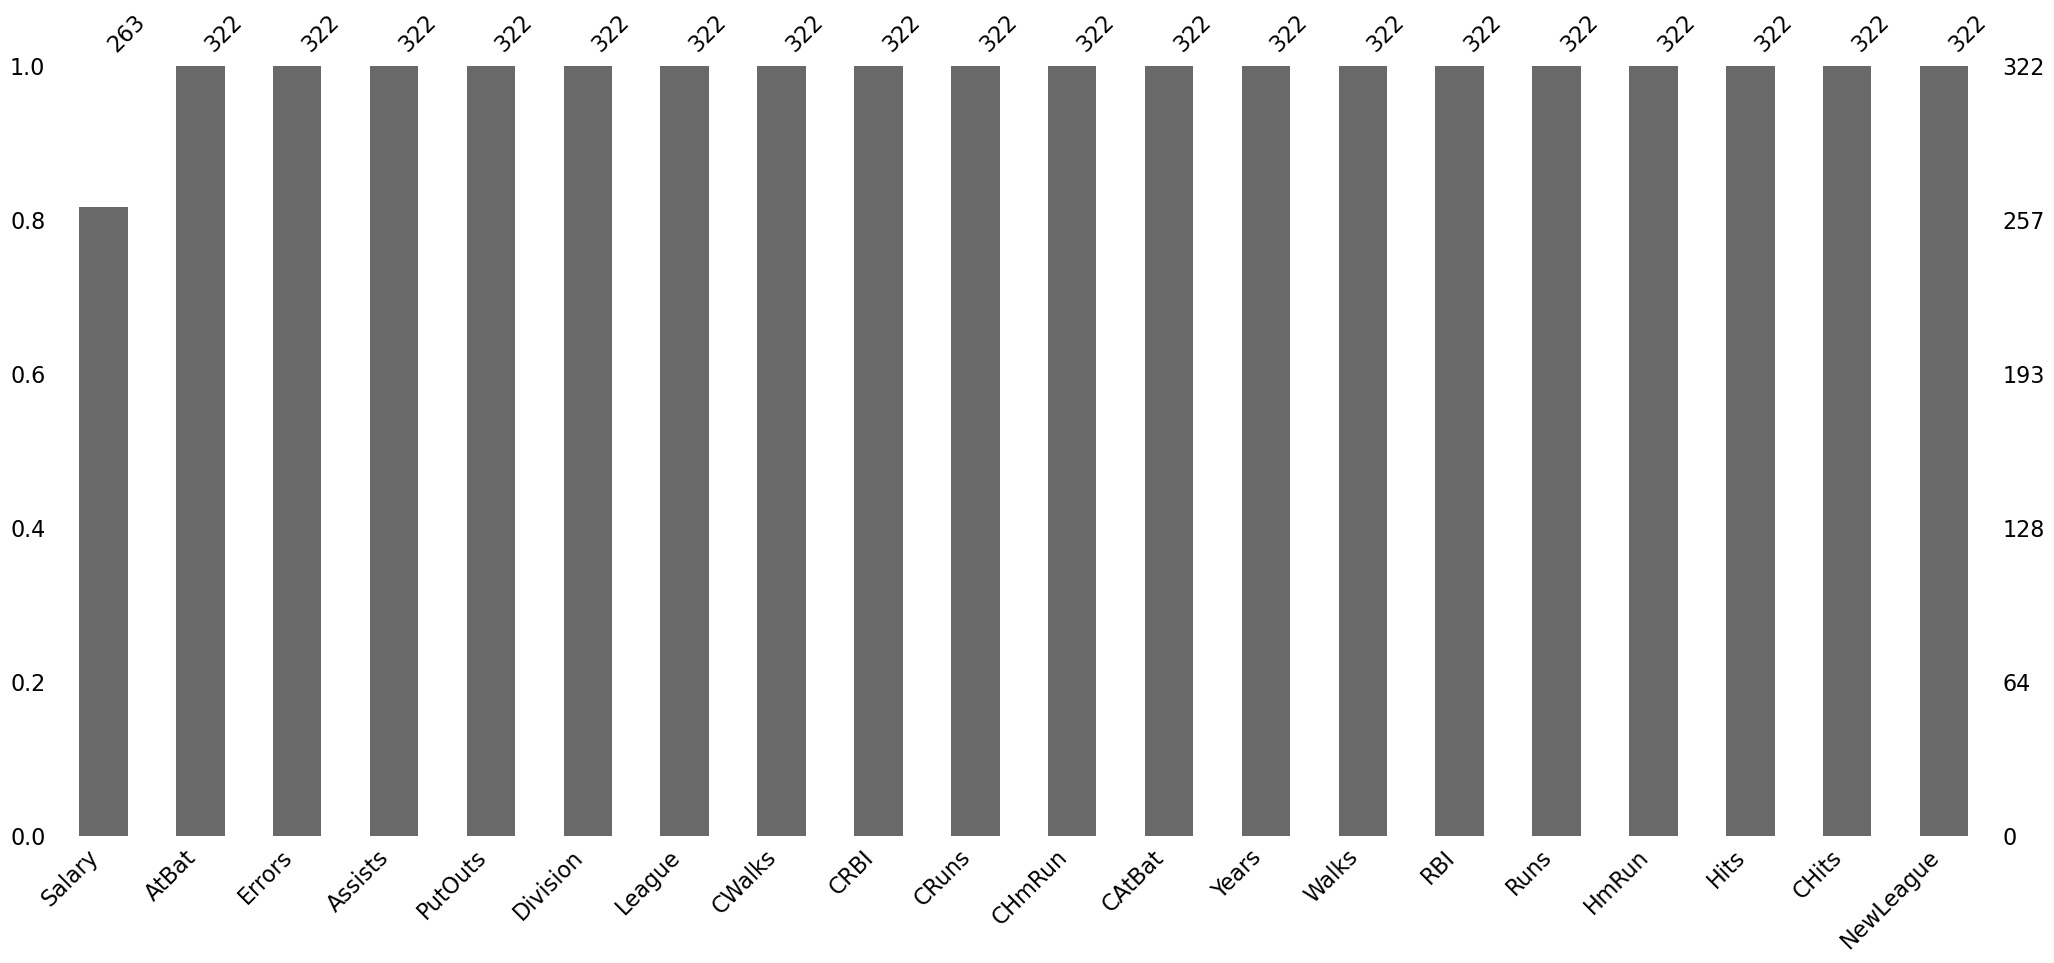

In [13]:
import missingno as msno
msno.bar(df, sort="ascending")

In [14]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")
    if na_name:
        return na_columns

In [15]:
missing_values_table(df)

        n_miss  ratio
Salary      59 18.320


In [16]:
df.groupby(["League", "Division"]).agg({"Salary": ["mean", "count"]})

Salary      
                   mean count
League Division              
A      E        670.850    68
       W        418.594    71
N      E        572.348    61
       W        487.259    63

In [17]:
# Filling the missing values according to the informations above
df["Salary"] = df["Salary"].fillna(df.groupby(["League", "Division"])["Salary"].transform("mean"))

# Checking the missing values again
missing_values_table(df)

Empty DataFrame
Columns: [n_miss, ratio]
Index: []


#### Outliers

In [18]:
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [19]:
for col in num_cols:
    print(col+":", check_outlier(df, col))

AtBat: False
Hits: False
HmRun: True
Runs: True
RBI: True
Walks: True
Years: True
CAtBat: True
CHits: True
CHmRun: True
CRuns: True
CRBI: True
CWalks: True
PutOuts: True
Assists: True
Errors: True
Salary: True


In [20]:
for col in num_cols:
    if check_outlier(df, col):
        replace_with_thresholds(df, col)

In [21]:
# Checking the outliers again
for col in num_cols:
    print(col+":", check_outlier(df, col))

AtBat: False
Hits: False
HmRun: False
Runs: False
RBI: False
Walks: False
Years: False
CAtBat: False
CHits: False
CHmRun: False
CRuns: False
CRBI: False
CWalks: False
PutOuts: False
Assists: False
Errors: False
Salary: False


#### Feature Engineering

In [22]:
new_num_cols=[col for col in num_cols if col!="Salary"]

df[new_num_cols]=df[new_num_cols]+0.0000000001

df['NEW_Hits'] = df['Hits'] / df['CHits'] + df['Hits']
df['NEW_RBI'] = df['RBI'] / df['CRBI']
df['NEW_Walks'] = df['Walks'] / df['CWalks']
df['NEW_PutOuts'] = df['PutOuts'] * df['Years']
df["Hits_Success"] = (df["Hits"] / df["AtBat"]) * 100
df["NEW_CRBI*CATBAT"] = df['CRBI'] * df['CAtBat']
df["NEW_RBI"] = df["RBI"] / df["CRBI"]
df["NEW_Chits"] = df["CHits"] / df["Years"]
df["NEW_CHmRun"] = df["CHmRun"] * df["Years"]
df["NEW_CRuns"] = df["CRuns"] / df["Years"]
df["NEW_Chits"] = df["CHits"] * df["Years"]
df["NEW_RW"] = df["RBI"] * df["Walks"]
df["NEW_RBWALK"] = df["RBI"] / df["Walks"]
df["NEW_CH_CB"] = df["CHits"] / df["CAtBat"]
df["NEW_CHm_CAT"] = df["CHmRun"] / df["CAtBat"]
df['NEW_Diff_Atbat'] = df['AtBat'] - (df['CAtBat'] / df['Years'])
df['NEW_Diff_Hits'] = df['Hits'] - (df['CHits'] / df['Years'])
df['NEW_Diff_HmRun'] = df['HmRun'] - (df['CHmRun'] / df['Years'])
df['NEW_Diff_Runs'] = df['Runs'] - (df['CRuns'] / df['Years'])
df['NEW_Diff_RBI'] = df['RBI'] - (df['CRBI'] / df['Years'])
df['NEW_Diff_Walks'] = df['Walks'] - (df['CWalks'] / df['Years'])

#### Encoding
##### One-Hot Encoding

In [23]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

In [24]:
df = one_hot_encoder(df, cat_cols, drop_first=True)

In [25]:
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary,NEW_Hits,NEW_RBI,NEW_Walks,NEW_PutOuts,Hits_Success,NEW_CRBI*CATBAT,NEW_Chits,NEW_CHmRun,NEW_CRuns,NEW_RW,NEW_RBWALK,NEW_CH_CB,NEW_CHm_CAT,NEW_Diff_Atbat,NEW_Diff_Hits,NEW_Diff_HmRun,NEW_Diff_Runs,NEW_Diff_RBI,NEW_Diff_Walks,League_N,Division_W,NewLeague_N
0,293.000,66.000,1.000,30.000,29.000,14.000,1.000,293.000,66.000,1.000,30.000,29.000,14.000,446.000,33.000,20.000,670.850,67.000,1.000,1.000,446.000,22.526,8497.000,66.000,1.000,30.000,406.000,2.071,0.225,0.003,0.000,0.000,0.000,0.000,0.000,0.000,0,0,0
1,315.000,81.000,7.000,24.000,38.000,39.000,14.000,3449.000,835.000,69.000,321.000,414.000,375.000,632.000,43.000,10.000,475.000,81.097,0.092,0.104,8848.000,25.714,1427886.000,11690.000,966.000,22.929,1482.000,0.974,0.242,0.020,68.643,21.357,2.071,1.071,8.429,12.214,1,1,1
2,479.000,130.000,18.000,66.000,72.000,76.000,3.000,1624.000,457.000,63.000,224.000,266.000,263.000,648.625,82.000,14.000,480.000,130.284,0.271,0.289,1945.875,27.140,431984.000,1371.000,189.000,74.667,5472.000,0.947,0.281,0.039,-62.333,-22.333,-3.000,-8.667,-16.667,-11.667,0,1,0
3,496.000,141.000,20.000,65.000,78.000,37.000,11.000,5628.000,1575.000,204.000,828.000,838.000,354.000,200.000,11.000,3.000,500.000,141.090,0.093,0.105,2200.000,28.427,4716264.000,17325.000,2244.000,75.273,2886.000,2.108,0.280,0.036,-15.636,-2.182,1.455,-10.273,1.818,4.818,1,0,1
4,321.000,87.000,10.000,39.000,42.000,30.000,2.000,396.000,101.000,12.000,48.000,46.000,33.000,648.625,40.000,4.000,91.500,87.861,0.913,0.909,1297.250,27.103,18216.000,202.000,24.000,24.000,1260.000,1.400,0.255,0.030,123.000,36.500,4.000,15.000,19.000,13.500,1,0,1


#### Scaling 

In [26]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

num_cols = [col for col in num_cols if col not in ["Salary"]]
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])
df.head()

Observations: 322
Variables: 39
cat_cols: 3
num_cols: 36
cat_but_car: 0
num_but_cat: 3


,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary,NEW_Hits,NEW_RBI,NEW_Walks,NEW_PutOuts,Hits_Success,NEW_CRBI*CATBAT,NEW_Chits,NEW_CHmRun,NEW_CRuns,NEW_RW,NEW_RBWALK,NEW_CH_CB,NEW_CHm_CAT,NEW_Diff_Atbat,NEW_Diff_Hits,NEW_Diff_HmRun,NEW_Diff_Runs,NEW_Diff_RBI,NEW_Diff_Walks,League_N,Division_W,NewLeague_N
0,-0.574,-0.755,-1.130,-0.805,-0.728,-1.147,-1.318,-1.043,-1.035,-0.956,-1.023,-0.995,-1.036,1.049,-0.549,1.977,670.850,-0.741,2.214,2.285,-0.658,-0.956,-0.672,-0.741,-0.682,-0.631,-0.901,0.829,-1.415,-1.363,-0.513,-0.456,-0.611,-0.422,-0.608,-0.624,0,0,0
1,-0.430,-0.432,-0.434,-1.036,-0.384,0.013,1.346,0.369,0.204,0.119,-0.105,0.363,0.582,2.060,-0.471,0.337,475.000,-0.437,-0.798,-0.767,3.224,-0.076,0.002,0.343,0.275,-0.967,-0.363,-0.558,-0.752,-0.230,0.091,0.195,-0.198,-0.363,-0.109,0.252,1,1,1
2,0.640,0.625,0.840,0.582,0.918,1.729,-0.908,-0.448,-0.405,0.024,-0.411,-0.159,0.080,2.151,-0.170,0.993,480.000,0.624,-0.204,-0.137,0.035,0.317,-0.471,-0.619,-0.496,1.493,1.634,-0.592,0.794,1.052,-1.061,-1.136,-1.209,-0.901,-1.594,-1.461,0,1,0
3,0.751,0.862,1.072,0.543,1.148,-0.080,0.731,1.344,1.396,2.254,1.495,1.859,0.488,-0.289,-0.719,-0.812,500.000,0.858,-0.793,-0.765,0.152,0.672,1.563,0.869,1.542,1.522,0.340,0.875,0.733,0.878,-0.651,-0.522,-0.321,-0.989,-0.500,-0.279,1,0,1
4,-0.391,-0.302,-0.087,-0.458,-0.231,-0.405,-1.113,-0.997,-0.979,-0.782,-0.966,-0.935,-0.951,2.151,-0.494,-0.648,91.500,-0.291,1.926,1.975,-0.265,0.307,-0.668,-0.728,-0.659,-0.916,-0.474,-0.020,-0.243,0.473,0.569,0.656,0.186,0.407,0.517,0.344,1,0,1


### Modelling

#### Train-Test Split

In [27]:
X = df.drop("Salary", axis=1)
y = df["Salary"]

#### Base Models

In [28]:
models = [('LR', LinearRegression()),
          ("Ridge", Ridge()),
          ("Lasso", Lasso()),
          ("ElasticNet", ElasticNet()),
          ('KNN', KNeighborsRegressor()),
          ('CART', DecisionTreeRegressor()),
          ('RF', RandomForestRegressor()),
          ('SVR', SVR()),
          ('GBM', GradientBoostingRegressor()),
          ("XGBoost", XGBRegressor(objective='reg:squarederror')),
          ("LightGBM", LGBMRegressor()),
          ("CatBoost", CatBoostRegressor(verbose=False))]

In [29]:
for name, regressor in models:
    rmse = np.mean(np.sqrt(-cross_val_score(regressor, X, y, cv=10, scoring="neg_mean_squared_error")))
    print(f"RMSE: {round(rmse, 4)} ({name}) ")

RMSE: 238.0669 (LR) 
RMSE: 232.2694 (Ridge) 
RMSE: 229.4801 (Lasso) 
RMSE: 257.4355 (ElasticNet) 
RMSE: 263.8183 (KNN) 
RMSE: 288.1694 (CART) 
RMSE: 219.3188 (RF) 
RMSE: 341.571 (SVR) 
RMSE: 223.3779 (GBM) 
RMSE: 243.7472 (XGBoost) 
RMSE: 225.2026 (LightGBM) 
RMSE: 221.9226 (CatBoost) 


#### Model Tuning and Evaluation 

##### Random Forest

In [30]:
rf_model = RandomForestRegressor(random_state=17)

In [31]:
rf_params = {"max_depth": [5, 8, 15, None],
             "min_samples_split": [8, 15, 20],
             "n_estimators": [200, 500]}

In [32]:
rf_best_grid = GridSearchCV(rf_model, rf_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [33]:
rf_final = rf_model.set_params(**rf_best_grid.best_params_, random_state=17).fit(X, y)

In [34]:
rmse = np.mean(np.sqrt(-cross_val_score(rf_final, X, y, cv=10, scoring="neg_mean_squared_error")))
rmse

218.8795989203888

##### GBM Model

In [35]:
gbm_model = GradientBoostingRegressor(random_state=17)

In [36]:
gbm_params = {"learning_rate": [0.01, 0.1],
              "max_depth": [3, 8],
              "n_estimators": [500, 1000],
              "subsample": [1, 0.5, 0.7]}

In [37]:
gbm_best_grid = GridSearchCV(gbm_model, gbm_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [38]:
gbm_final = gbm_model.set_params(**gbm_best_grid.best_params_, random_state=17).fit(X, y)

In [39]:
rmse = np.mean(np.sqrt(-cross_val_score(gbm_final, X, y, cv=10, scoring="neg_mean_squared_error")))
rmse

215.5455640313815

##### LightGBM

In [40]:
lgbm_model = LGBMRegressor(random_state=17)

In [41]:
lgbm_params = {"learning_rate": [0.01, 0.1],
                "n_estimators": [300, 500],
                "colsample_bytree": [0.7, 1]}

In [42]:
lgbm_best_grid = GridSearchCV(lgbm_model, lgbm_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [43]:
lgbm_final = lgbm_model.set_params(**lgbm_best_grid.best_params_, random_state=17).fit(X, y)

In [44]:
rmse = np.mean(np.sqrt(-cross_val_score(lgbm_final, X, y, cv=10, scoring="neg_mean_squared_error")))
rmse

220.08426405288523

##### CatBoost

In [45]:
catboost_model = CatBoostRegressor(random_state=17, verbose=False)

In [46]:
catboost_params = {"iterations": [200, 500],
                   "learning_rate": [0.01, 0.1],
                   "depth": [3, 6]}

In [47]:
catboost_best_grid = GridSearchCV(catboost_model, catboost_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [48]:
catboost_final = catboost_model.set_params(**catboost_best_grid.best_params_, random_state=17).fit(X, y)

In [49]:
rmse = np.mean(np.sqrt(-cross_val_score(catboost_final, X, y, cv=10, scoring="neg_mean_squared_error")))
rmse

220.84714839710787

#### Hyperparameter Optimization

In [50]:
rf_params = {"max_depth": [5, 8, 15, None],
             "min_samples_split": [8, 15, 20],
             "n_estimators": [200, 500]}

gbm_params = {"learning_rate": [0.01, 0.1],
              "max_depth": [3, 8],
              "n_estimators": [500, 1000],
              "subsample": [1, 0.5, 0.7]}

lightgbm_params = {"learning_rate": [0.01, 0.1],
                   "n_estimators": [300, 500],
                   "colsample_bytree": [0.7, 1]}

regressors = [("RF", RandomForestRegressor(), rf_params),
              ('GBM', GradientBoostingRegressor(), gbm_params),
              ('LightGBM', LGBMRegressor(), lightgbm_params)]

best_models = {}


In [51]:
for name, regressor, params in regressors:
    print(f"########## {name} ##########")
    rmse = np.mean(np.sqrt(-cross_val_score(regressor, X, y, cv=10, scoring="neg_mean_squared_error")))
    print(f"RMSE: {round(rmse, 4)} ({name}) ")

    gs_best = GridSearchCV(regressor, params, cv=3, n_jobs=-1, verbose=False).fit(X, y)

    final_model = regressor.set_params(**gs_best.best_params_)
    rmse = np.mean(np.sqrt(-cross_val_score(final_model, X, y, cv=10, scoring="neg_mean_squared_error")))
    print(f"RMSE (After): {round(rmse, 4)} ({name}) ")

    print(f"{name} best params: {gs_best.best_params_}", end="\n\n")

    best_models[name] = final_model

########## RF ##########
RMSE: 218.4459 (RF) 
RMSE (After): 217.5093 (RF) 
RF best params: {'max_depth': 15, 'min_samples_split': 8, 'n_estimators': 500}

########## GBM ##########
RMSE: 225.3924 (GBM) 
RMSE (After): 214.7437 (GBM) 
GBM best params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.7}

########## LightGBM ##########
RMSE: 225.2026 (LightGBM) 
RMSE (After): 219.7886 (LightGBM) 
LightGBM best params: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'n_estimators': 300}



#### Feature Importance

In [52]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

RandomForestRegressor(max_depth=8, min_samples_split=8, n_estimators=200,
                      random_state=17)


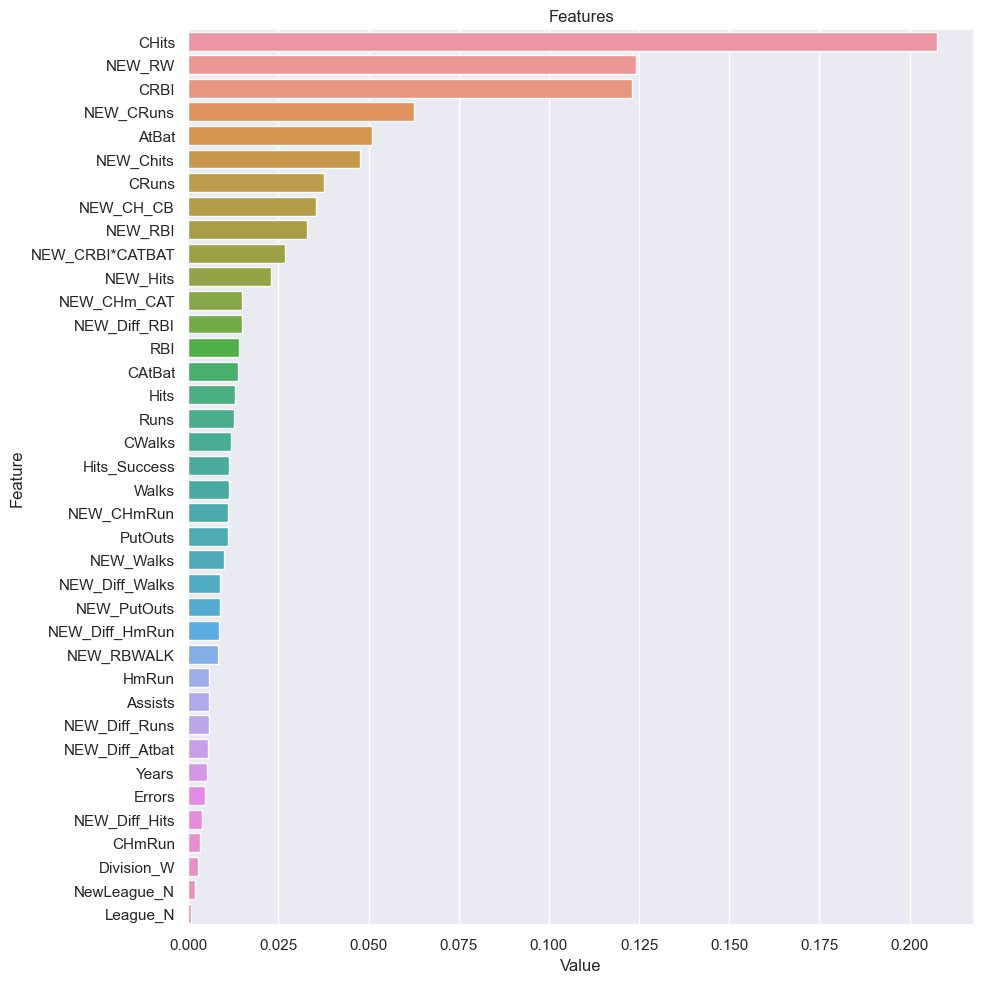

____________________________________________________________________________________________________
GradientBoostingRegressor(learning_rate=0.01, n_estimators=500, random_state=17,
                          subsample=0.7)


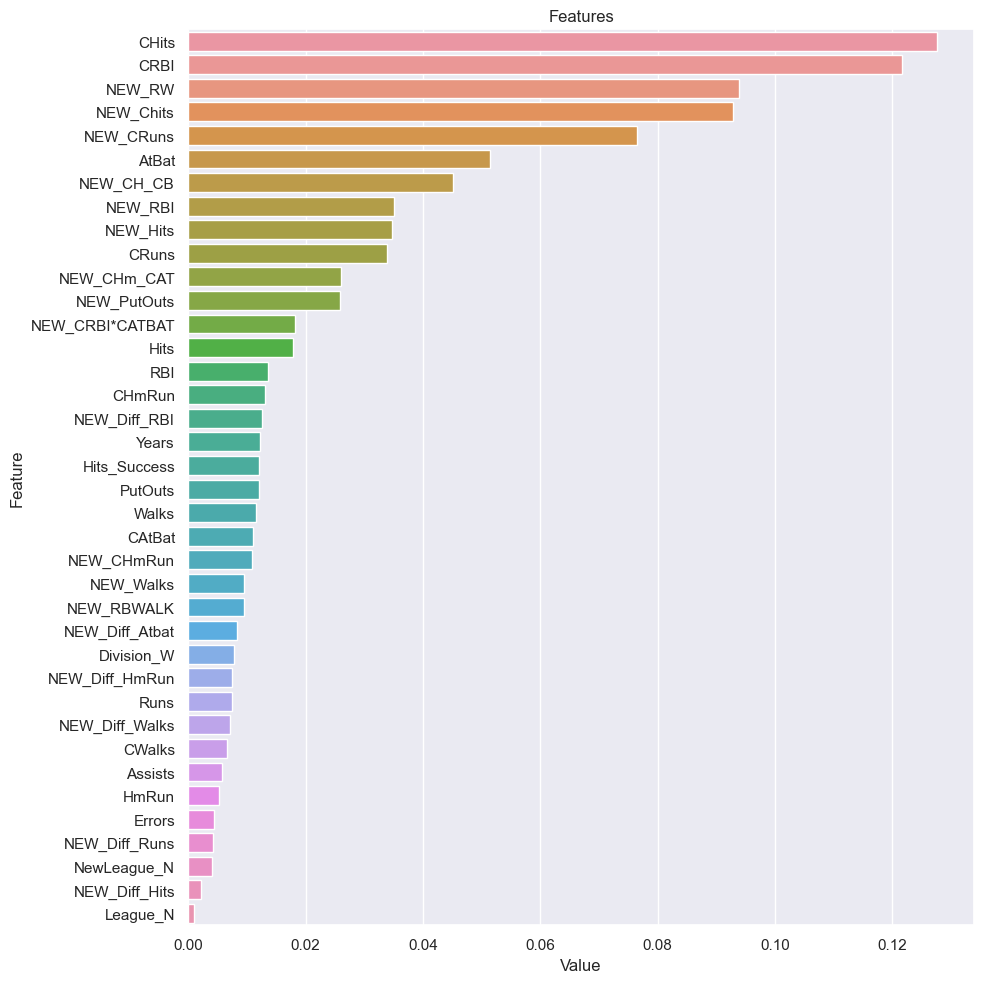

____________________________________________________________________________________________________
LGBMRegressor(colsample_bytree=1, learning_rate=0.01, n_estimators=500,
              random_state=17)


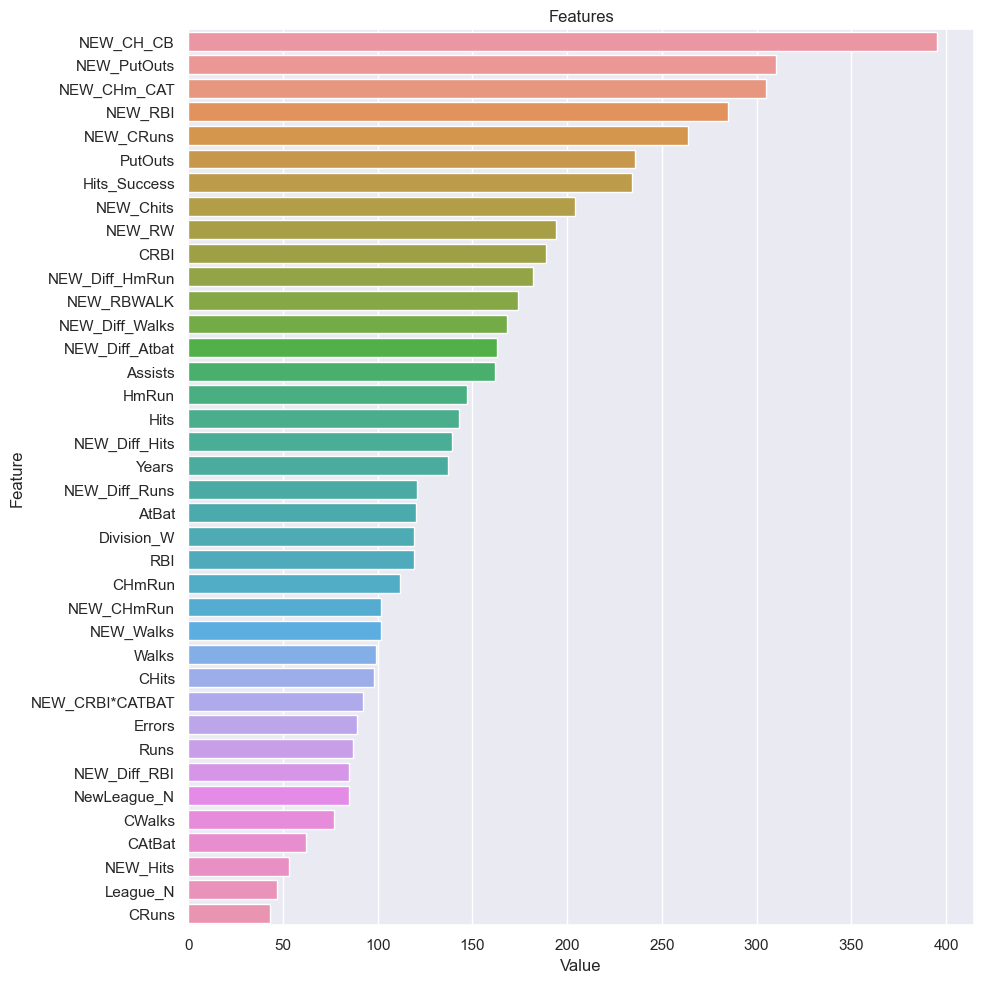

____________________________________________________________________________________________________


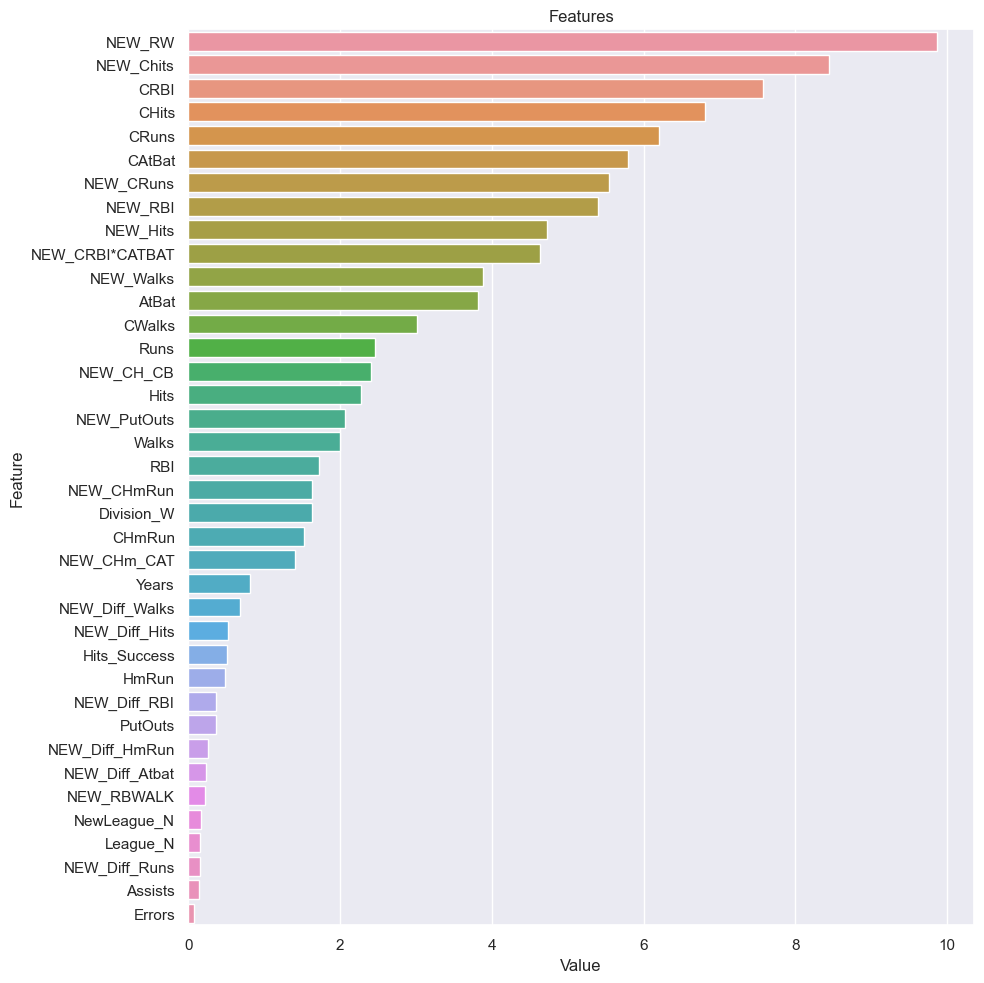

____________________________________________________________________________________________________


In [53]:
model_list = [rf_final, gbm_final, lgbm_final, catboost_final]

for i in model_list:
    print(i)
    plot_importance(i, X)
    print("_"*100)